In [1]:
import os

import cv2
from PIL import Image

from taiwan_license_plate_recognition.PostProcess import filter_license_number
from taiwan_license_plate_recognition.Utils import extract_license_number_paddleocr, extract_license_plate

In [2]:
%load_ext dotenv
%dotenv
%matplotlib inline

In [4]:
project_root: str = os.environ.get("PROJECT_ROOT", "")
test_multi_image_path: str = (
	f"{project_root}/datasets/roboflow/test/images/001509_jpg.rf.d3623b6cb4487f86d0e4ff503f2f234b.jpg"
)

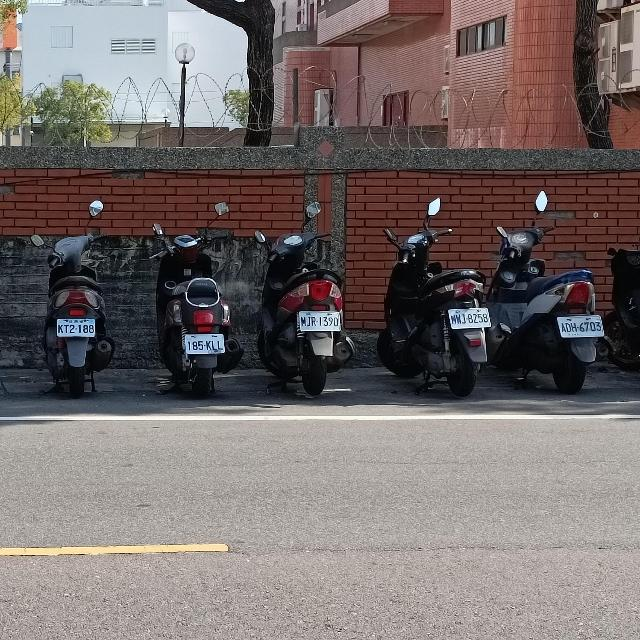

In [5]:
image = Image.open(test_multi_image_path)
image

In [6]:
image.size

(640, 640)

In [7]:
from ultralytics import YOLO

yolo_model = YOLO(f"{project_root}/artifacts/license-plate-detection:v0_openvino_model", task="obb")

In [8]:
results = yolo_model.predict(test_multi_image_path)

Loading /home/hermeschen/Repo/taiwan-license-plate-recognition/artifacts/license-plate-detection:v0_openvino_model for OpenVINO inference...

image 1/1 /home/hermeschen/Repo/taiwan-license-plate-recognition/datasets/roboflow/test/images/001509_jpg.rf.d3623b6cb4487f86d0e4ff503f2f234b.jpg: 640x640 29.1ms
Speed: 7.7ms preprocess, 29.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
images = extract_license_plate(results)

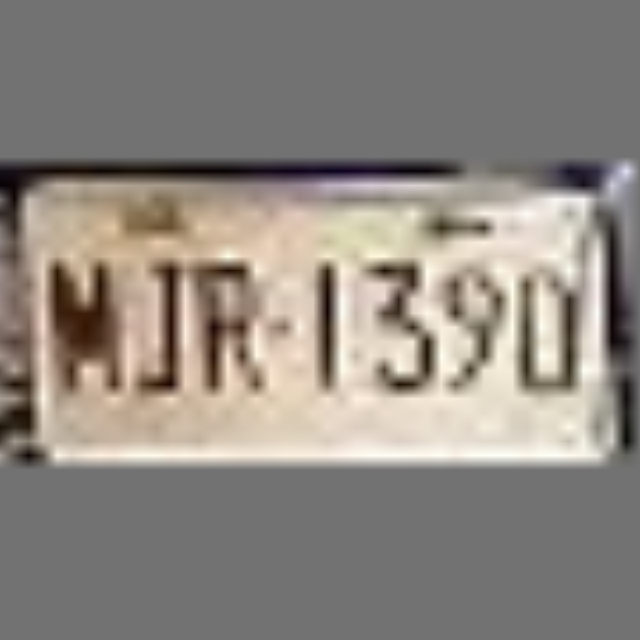

In [10]:
Image.fromarray(cv2.cvtColor(images[4], cv2.COLOR_BGR2RGB))

# EasyOCR

In [11]:
import easyocr

In [12]:
reader = easyocr.Reader(["en"], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [14]:
result: str = reader.readtext(image)
result

[([[299, 315], [341, 315], [341, 329], [299, 329]],
  'MJF |39u',
  0.18842195030535644),
 ([[449, 311], [491, 311], [491, 325], [449, 325]],
  '019258',
  0.11556725479558327),
 ([[55, 321], [97, 321], [97, 337], [55, 337]], 'KT2 v88', 0.2955125415353417),
 ([[559, 319], [603, 319], [603, 335], [559, 335]],
  'dx-6703',
  0.47096114715669285),
 ([[185, 339], [225, 339], [225, 353], [185, 353]],
  '185 KLLI',
  0.2845425436939395)]

# PaddleOCR

In [15]:
from paddleocr import PaddleOCR

In [16]:
reader = PaddleOCR(
	lang="en",
	device="cpu",
	use_angle_cls=True,
	total_process_num=8,
	use_mp=True,
	max_text_length=8,
	use_space_char=False,
	binarize=True,
)

[2024/12/12 17:59:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/hermeschen/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/hermeschen/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max

In [21]:
import itertools

predictions = [reader.ocr(image) for image in images]

results = [result[0][1][0] for result in filter(None, itertools.chain.from_iterable(predictions))]

results

[2024/12/12 18:00:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013899564743041992
[2024/12/12 18:00:50] ppocr DEBUG: cls num  : 1, elapsed : 0.0037920475006103516
[2024/12/12 18:00:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.007913351058959961
[2024/12/12 18:00:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012278079986572266
[2024/12/12 18:00:50] ppocr DEBUG: cls num  : 1, elapsed : 0.0019235610961914062
[2024/12/12 18:00:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.010278940200805664
[2024/12/12 18:00:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012131929397583008
[2024/12/12 18:00:50] ppocr DEBUG: cls num  : 1, elapsed : 0.002229452133178711
[2024/12/12 18:00:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.010730981826782227
[2024/12/12 18:00:50] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.019031047821044922
[2024/12/12 18:00:50] ppocr DEBUG: cls num  : 1, elapsed : 0.0029938220977783203
[2024/12/12 18:00:50] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0084381103515625
[2024/1

['KT2-188', 'ADH-6703', '185-KLL', 'MJR-1390']

In [22]:
[filter_license_number(result) for result in results]

['', '', '', '']

In [19]:
extract_license_number_paddleocr(images, reader)

[2024/12/12 17:59:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012917280197143555
[2024/12/12 17:59:43] ppocr DEBUG: cls num  : 1, elapsed : 0.002685546875
[2024/12/12 17:59:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009002685546875
[2024/12/12 17:59:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.014871358871459961
[2024/12/12 17:59:43] ppocr DEBUG: cls num  : 1, elapsed : 0.0032339096069335938
[2024/12/12 17:59:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.01703500747680664
[2024/12/12 17:59:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013822555541992188
[2024/12/12 17:59:43] ppocr DEBUG: cls num  : 1, elapsed : 0.019187450408935547
[2024/12/12 17:59:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009437322616577148
[2024/12/12 17:59:43] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013695955276489258
[2024/12/12 17:59:43] ppocr DEBUG: cls num  : 1, elapsed : 0.0026519298553466797
[2024/12/12 17:59:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009135007858276367
[2024/12/12 17:5

['', '', '', '']

# Tesseract

In [55]:
import pytesseract

In [56]:
tesseract_config: str = "--psm 6 --oem 1"

In [57]:
result = pytesseract.image_to_string(image, lang="eng", config=tesseract_config)
result

': a\nOS st i\n\nCC a Tit\nom (C\\ 4 | K i\n\n\\ o i |\n\\ J el | 4 Uy * 330\nWI Se C=\n\n«Nn ane ,\n'

# TrOCR

In [58]:
from optimum.intel import OVModelForVision2Seq
from transformers import TrOCRProcessor

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [59]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed", clean_up_tokenization_spaces=True)

In [60]:
model = OVModelForVision2Seq.from_pretrained(
	"DunnBC22/trocr-base-printed_license_plates_ocr", export=True, device="cpu"
)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

KeyboardInterrupt: 

In [21]:
encode_image = processor(image.convert("RGB"), return_tensors="pt").pixel_values

In [22]:
generated_ids = model.generate(encode_image, max_length=20)



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1733642252 (unix time) try "date -d @1733642252" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e80002d74f) received by PID 186571 (TID 0x7f23115ff6c0) from PID 186191 ***]



--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
No stack trace in paddle, may be caused by external reasons.

----------------------
Error Message Summary:
----------------------
FatalError: `Termination signal` is detected by the operating system.
  [TimeInfo: *** Aborted at 1733642252 (unix time) try "date -d @1733642252" if you are using GNU date ***]
  [SignalInfo: *** SIGTERM (@0x3e8

In [23]:
result = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
result

'0009DK'